In [1]:
import numpy as np

In [2]:
import pandas as pd 
import seaborn as sns 
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from scipy.stats import norm, skew #for some statistics
from scipy import stats #qqplot
from matplotlib import rcParams


In [3]:
import statsmodels.api as sm

In [4]:
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.impute import SimpleImputer
Imputer = SimpleImputer(missing_values=np.nan, strategy='mean')

In [5]:
df = pd.read_csv('/home/bami123/Historical Product Demand.csv')

In [6]:
df.head()

,Product_Code,Warehouse,Product_Category,Date,Order_Demand
0,Product_0993,Whse_J,Category_028,2012/7/27,100
1,Product_0979,Whse_J,Category_028,2012/1/19,500
2,Product_0979,Whse_J,Category_028,2012/2/3,500
3,Product_0979,Whse_J,Category_028,2012/2/9,500
4,Product_0979,Whse_J,Category_028,2012/3/2,500


In [7]:

print(df.shape)
print(df.dtypes)

(1048575, 5)
Product_Code        object
Warehouse           object
Product_Category    object
Date                object
Order_Demand        object
dtype: object


In [8]:
df.isnull().sum()
# calculating % of data missing
print("% of Data missing =", df.isnull().sum().sum()/len(df)*100)


% of Data missing = 1.0718355863910547


In [9]:

df.dropna(axis=0, inplace=True) #remove all rows with Nan

#setting date as index columns
df.reset_index(drop = True)
df.isnull().sum()


Product_Code        0
Warehouse           0
Product_Category    0
Date                0
Order_Demand        0
dtype: int64

In [10]:
df.sort_values('Date')[10:20]

,Product_Code,Warehouse,Product_Category,Date,Order_Demand
44795,Product_0965,Whse_A,Category_006,2011/11/18,1
44796,Product_0965,Whse_A,Category_006,2011/11/21,3
44797,Product_0965,Whse_A,Category_006,2011/11/21,5
44798,Product_0965,Whse_A,Category_006,2011/11/21,2
119561,Product_0980,Whse_A,Category_028,2011/11/21,100
107158,Product_0138,Whse_J,Category_007,2011/11/22,188
107159,Product_0138,Whse_J,Category_007,2011/11/22,1852
111727,Product_0982,Whse_A,Category_028,2011/11/22,3700
44102,Product_0980,Whse_A,Category_028,2011/11/23,1000
71915,Product_0980,Whse_A,Category_028,2011/11/23,200


In [11]:
df['Order_Demand'] = df['Order_Demand'].str.replace('(',"")
df['Order_Demand'] = df['Order_Demand'].str.replace(')',"")
df.sort_values('Date')[10:20]

<ipython-input-11-38e495dfe84a>:1: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will*not* be treated as literal strings when regex=True.
  df['Order_Demand'] = df['Order_Demand'].str.replace('(',"")
<ipython-input-11-38e495dfe84a>:2: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will*not* be treated as literal strings when regex=True.
  df['Order_Demand'] = df['Order_Demand'].str.replace(')',"")


,Product_Code,Warehouse,Product_Category,Date,Order_Demand
44795,Product_0965,Whse_A,Category_006,2011/11/18,1
44796,Product_0965,Whse_A,Category_006,2011/11/21,3
44797,Product_0965,Whse_A,Category_006,2011/11/21,5
44798,Product_0965,Whse_A,Category_006,2011/11/21,2
119561,Product_0980,Whse_A,Category_028,2011/11/21,100
107158,Product_0138,Whse_J,Category_007,2011/11/22,188
107159,Product_0138,Whse_J,Category_007,2011/11/22,1852
111727,Product_0982,Whse_A,Category_028,2011/11/22,3700
44102,Product_0980,Whse_A,Category_028,2011/11/23,1000
71915,Product_0980,Whse_A,Category_028,2011/11/23,200


In [12]:
df['Order_Demand'] = df['Order_Demand'].astype('int64')

/home/bami123/.local/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


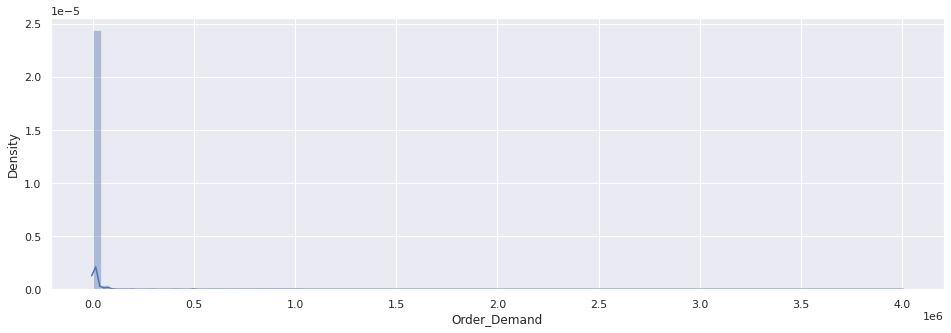

In [13]:
sns.set(rc={'figure.figsize':(16,5)})
sns.distplot(df['Order_Demand'], bins = 100);

<AxesSubplot:xlabel='Date', ylabel='Order_Demand'>

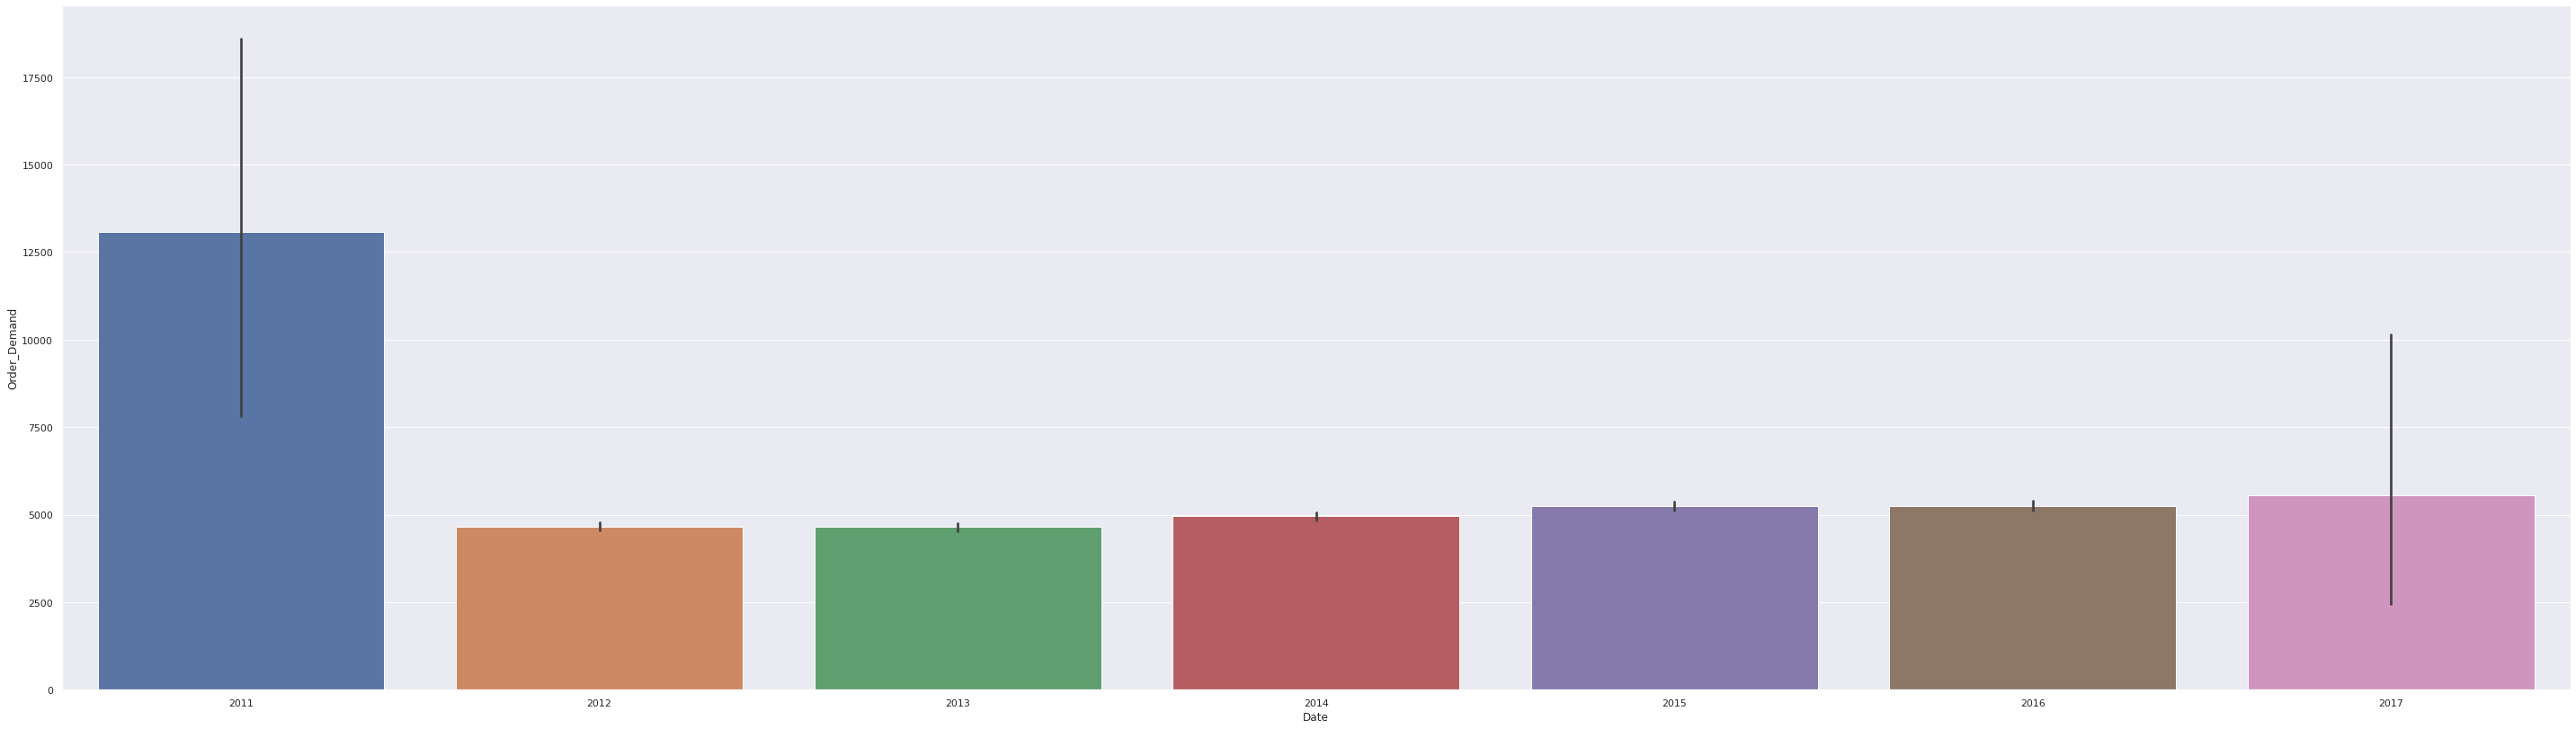

In [14]:
rcParams['figure.figsize'] = 50,14
sns.barplot(x=pd.DatetimeIndex(df['Date']).year, y=df['Order_Demand'])

/home/bami123/.local/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


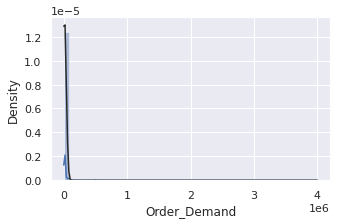

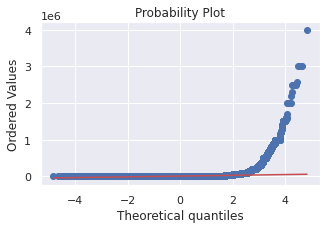

In [15]:
import seaborn as sns
rcParams['figure.figsize'] = 5,3
sns.distplot(df['Order_Demand'], fit=norm)
#Get the QQ-plot
fig = plt.figure()
res = stats.probplot(df['Order_Demand'], plot=plt)
plt.show()

<AxesSubplot:xlabel='Date', ylabel='Order_Demand'>

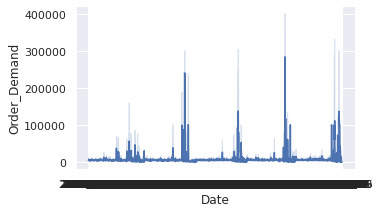

In [16]:
sns.lineplot(x=df['Date'], y=df['Order_Demand'])


In [17]:
df.groupby('Warehouse')['Order_Demand'].sum().sort_values(ascending=False)

Warehouse
Whse_J    3363200396
Whse_S    1038024700
Whse_C     585071404
Whse_A     147877431
Name: Order_Demand, dtype: int64

In [18]:
df1 = pd.DataFrame(df.groupby('Product_Category')['Order_Demand'].sum().sort_values(ascending=False))
df1["% Contribution"] = df1['Order_Demand']/df1['Order_Demand'].sum()*100
df1

,Order_Demand,% Contribution
Product_Category,,
Category_019,4240159257,82.586981
Category_006,405571330,7.899447
Category_005,199674520,3.889127
Category_007,128691531,2.506567
Category_028,49055354,0.955467
Category_033,42610000,0.829929
Category_030,40966555,0.797919
Category_021,4480570,0.087270
Category_032,4473048,0.087123


In [19]:
df["Date"] = pd.to_datetime(df["Date"])
df2 = pd.pivot_table(df,index=["Date"],values=["Order_Demand"],columns=["Product_Category"],aggfunc=np.sum)
df2.columns = df2.columns.droplevel(0)
df2["Category_019"].dropna()

Date
2011-06-24     92000.0
2011-09-02      1250.0
2011-10-31         3.0
2011-11-24     40000.0
2011-11-25     17250.0
                ...   
2016-12-30    621700.0
2017-01-04     19000.0
2017-01-05     18800.0
2017-01-06    169000.0
2017-01-09      4000.0
Name: Category_019, Length: 1606, dtype: float64

In [20]:
y = df2.resample('M').sum() # Resampling the data on monthly basis 
y.index.freq = "M" # Setting datetime frequency to Month
y.head(20)

Product_Category,Category_001,Category_002,Category_003,Category_004,Category_005,Category_006,Category_007,Category_008,Category_009,Category_010,...,Category_024,Category_025,Category_026,Category_027,Category_028,Category_029,Category_030,Category_031,Category_032,Category_033
Date,,,,,,,,,,,,,,,,,,,,,
2011-01-31,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2011-02-28,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2011-03-31,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2011-04-30,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2011-05-31,0.0,0.0,108.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2011-06-30,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2011-07-31,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2011-08-31,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2011-09-30,28.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [21]:
df_019 = pd.DataFrame(y["Category_019"].iloc[12:-1]) # Including data from 2012 to 2016 end except last value
df_019.head()

,Category_019
Date,
2012-01-31,61243661.0
2012-02-29,72219508.0
2012-03-31,72444888.0
2012-04-30,61382420.0
2012-05-31,72041920.0


In [22]:
predictors=['Product_Code','Warehouse','Product_Category','Date']
X=df[predictors]
y=df.Order_Demand
train_X, val_X, train_y, val_y = train_test_split(X, y, random_state=1,test_size=0.1,train_size=0.5)
one_hot_encoding_val_data=pd.get_dummies(val_X)
one_hot_encoding_train_data=pd.get_dummies(train_X)
del val_X
del train_X
final_train, final_val = one_hot_encoding_train_data.align(one_hot_encoding_val_data,join='left',axis=1)
#final val and final train are X 
del one_hot_encoding_val_data
del one_hot_encoding_train_data

final_train = Imputer.fit_transform(final_train)
final_val = Imputer.transform(final_val)
#define model 
my_model = XGBRegressor()
# Add silent=True to avoid printing out updates with each cycle
my_model.fit(final_train, train_y, verbose=False)
del final_train
del train_y
# make predictions
predictions = my_model.predict(final_val)
del final_val
print("Mean Absolute Error : " + str(mean_absolute_error(predictions, val_y)))


TypeError: The DTypes <class 'numpy.dtype[uint8]'> and <class 'numpy.dtype[datetime64]'> do not have a common DType. For example they cannot be stored in a single array unless the dtype is `object`.